Pytorch CV

In [18]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image
from IPython.display import display
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary
from tqdm import tqdm
import opendatasets as od

use_MPS = torch.backends.mps.is_available()
mps = torch.device("mps")

In [19]:
od.download("https://www.kaggle.com/datasets/tolgadincer/labeled-chest-xray-images")

Skipping, found downloaded files in "./labeled-chest-xray-images" (use force=True to force download)


In [20]:
class_name = ['NORMAL','PNEUMONIA']
def get_list_files(dirName):
    '''
    input - directory location
    output - list the files in the directory
    '''
    files_list = os.listdir(dirName)
    return files_list

data_path = "labeled-chest-xray-images/chest_xray"
files_list_normal_train = get_list_files(data_path+'/train/'+class_name[0])
files_list_pneu_train = get_list_files(data_path+'/train/'+class_name[1])
files_list_normal_test = get_list_files(data_path+'/test/'+class_name[0])
files_list_pneu_test = get_list_files(data_path+'/test/'+class_name[1])



In [21]:
print("Number of train samples in Normal category {}".
format(len(files_list_normal_train)))
print("Number of train samples in Pneumonia category {}".
format(len(files_list_pneu_train)))
print("Number of test samples in Normal category {}".
format(len(files_list_normal_test)))
print("Number of test samples in Pneumonia category {}".
format(len(files_list_pneu_test)))

Number of train samples in Normal category 1349
Number of train samples in Pneumonia category 3883
Number of test samples in Normal category 234
Number of test samples in Pneumonia category 390


(1418, 1882)


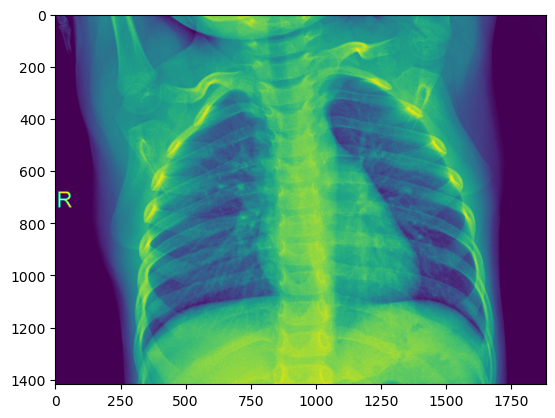

In [5]:
rand_img_no = np.random.randint(0,len(files_list_normal_train))
img = data_path + '/train/NORMAL/'+ files_list_normal_train[rand_img_no]
print(plt.imread(img).shape)
#display(Image.open(img,'r'),)
img = mpimg.imread(img)
imgplot = plt.imshow(img)
plt.show()

(680, 896)


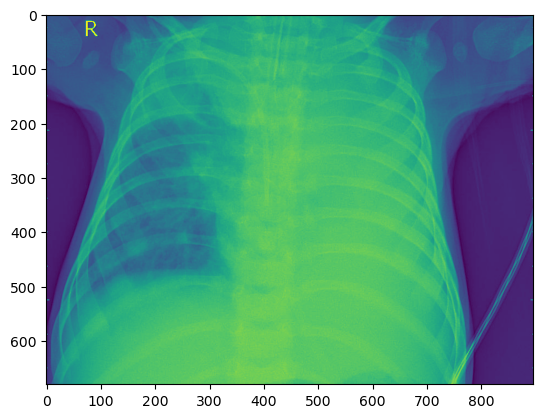

In [6]:
img = data_path + '/train/PNEUMONIA/'+ files_list_pneu_train[np.random.randint(0,len(files_list_pneu_train))]
print(plt.imread(img).shape)
img = mpimg.imread(img)
imgplot = plt.imshow(img)
plt.show()


In [66]:
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                          [0.229, 0.224, 0.225])])
    
test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                          [0.229, 0.224, 0.225])])

train_data = datasets.ImageFolder(os.path.join(data_path,'train'), transform= train_transform)

test_data = datasets.ImageFolder(os.path.join(data_path,'test'), transform= test_transform)

    
train_loader = DataLoader(train_data,
                          batch_size= 16, 
                          shuffle= True, 
                          pin_memory= True)
    
test_loader = DataLoader(test_data,
                         batch_size= 1, 
                         shuffle= False, 
                         pin_memory= True)

    
class_names = train_data.classes
print(class_names)
print(f'Number of train images: {len(train_data)}')
print(f'Number of test images: {len(test_data)}')

['NORMAL', 'PNEUMONIA']
Number of train images: 5232
Number of test images: 624


In [44]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(3, 3),padding=0, bias=False),
            nn.ReLU(),
            #nn.BatchNorm2d(4)
        )
        self.pool11 = nn.MaxPool2d(2, 2)
        # CONVOLUTION BLOCK
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3),padding=0, bias=False),
            nn.ReLU(),
            #nn.BatchNorm2d(16)
        )
        
                # TRANSITION BLOCK
        self.pool22 = nn.MaxPool2d(2, 2)
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            #nn.BatchNorm2d(10),
            nn.ReLU()
        )
        self.pool33 = nn.MaxPool2d(2, 2)
        # CONVOLUTION BLOCK
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            #nn.BatchNorm2d(10)
        )
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
            #nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            #nn.BatchNorm2d(10),
        )
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            #nn.BatchNorm2d(10)
        )
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
            #nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            #nn.BatchNorm2d(10),
        )
        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            #nn.BatchNorm2d(14),
        )
        self.convblock11 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
        #nn.BatchNorm2d(16),
        )
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        )
        self.convblockout = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=2, kernel_size=(4, 4), padding=0, bias=False),
        )
    def forward(self, x):
        x = self.convblock1(x)
        x = self.pool11(x)
        x = self.convblock2(x)
        x = self.pool22(x)
        x = self.convblock3(x)
        x = self.pool33(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.convblock10(x)
        x = self.convblock11(x)
        x = self.gap(x)
        x = self.convblockout(x)
        x = x.view(-1, 2)
        return F.log_softmax(x, dim=-1)

    
mps = torch.device("mps")
cpu = torch.device("cpu")
modelSummary = Net().to(cpu)
summary(modelSummary, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 222, 222]             216
              ReLU-2          [-1, 8, 222, 222]               0
         MaxPool2d-3          [-1, 8, 111, 111]               0
            Conv2d-4         [-1, 16, 109, 109]           1,152
              ReLU-5         [-1, 16, 109, 109]               0
         MaxPool2d-6           [-1, 16, 54, 54]               0
            Conv2d-7           [-1, 10, 54, 54]             160
              ReLU-8           [-1, 10, 54, 54]               0
         MaxPool2d-9           [-1, 10, 27, 27]               0
           Conv2d-10           [-1, 10, 25, 25]             900
             ReLU-11           [-1, 10, 25, 25]               0
           Conv2d-12           [-1, 32, 25, 25]             320
             ReLU-13           [-1, 32, 25, 25]               0
           Conv2d-14           [-1, 10,

In [40]:

#print("Available processor {}".format(device))


In [42]:
torch.backends.mps.is_built()

True

In [59]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        # get data
        data, target = data.to(device), target.to(device)
        # Initialization of gradient
        optimizer.zero_grad()
        # In PyTorch, gradient is accumulated over backprop andeven though thats used in RNN generally not used in CNN
        # or specific requirements
        ## prediction on data
        y_pred = model(data)
        # Calculating loss given the prediction
        loss = F.nll_loss(y_pred, target)
        train_losses.append(loss)
        # Backprop
        loss.backward()
        optimizer.step()
        # get the index of the log-probability corresponding to  the max value
        pred = y_pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)
                             
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device) 
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{}({:.2f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
    test_acc.append(100. * correct / len(test_loader.dataset))


In [60]:
model =  Net().to(mps)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01,
momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.5)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    print('current Learning Rate: ', optimizer.state_dict()
    ["param_groups"][0]["lr"])
    test(model, device, test_loader)

EPOCH: 0


Loss=0.6931456327438354 Batch_id=326 Accuracy=68.98: 100%|█| 327/327 [00:58<00:0


current Learning Rate:  0.01

Test set: Average loss: 0.6931, Accuracy: 379/624(60.74%)

EPOCH: 1


Loss=0.6931473612785339 Batch_id=326 Accuracy=70.37: 100%|█| 327/327 [00:57<00:0


current Learning Rate:  0.01

Test set: Average loss: 0.6931, Accuracy: 385/624(61.70%)

EPOCH: 2


Loss=0.6931450366973877 Batch_id=326 Accuracy=72.08: 100%|█| 327/327 [00:58<00:0


current Learning Rate:  0.01

Test set: Average loss: 0.6931, Accuracy: 394/624(63.14%)

EPOCH: 3


Loss=0.6931438446044922 Batch_id=326 Accuracy=72.95: 100%|█| 327/327 [00:57<00:0


current Learning Rate:  0.01

Test set: Average loss: 0.6931, Accuracy: 398/624(63.78%)

EPOCH: 4


Loss=0.6931427717208862 Batch_id=326 Accuracy=73.59: 100%|█| 327/327 [00:58<00:0


current Learning Rate:  0.01

Test set: Average loss: 0.6931, Accuracy: 393/624(62.98%)

EPOCH: 5


Loss=0.693143904209137 Batch_id=326 Accuracy=73.87: 100%|█| 327/327 [00:58<00:00


current Learning Rate:  0.005

Test set: Average loss: 0.6931, Accuracy: 391/624(62.66%)

EPOCH: 6


Loss=0.6931444406509399 Batch_id=326 Accuracy=74.08: 100%|█| 327/327 [00:58<00:0


current Learning Rate:  0.005

Test set: Average loss: 0.6931, Accuracy: 390/624(62.50%)

EPOCH: 7


Loss=0.6931403279304504 Batch_id=326 Accuracy=74.18: 100%|█| 327/327 [00:58<00:0


current Learning Rate:  0.005

Test set: Average loss: 0.6931, Accuracy: 390/624(62.50%)

EPOCH: 8


Loss=0.6931368112564087 Batch_id=326 Accuracy=74.20: 100%|█| 327/327 [00:58<00:0


current Learning Rate:  0.005

Test set: Average loss: 0.6931, Accuracy: 390/624(62.50%)

EPOCH: 9


Loss=0.6931397914886475 Batch_id=326 Accuracy=74.22: 100%|█| 327/327 [00:58<00:0


current Learning Rate:  0.005

Test set: Average loss: 0.6931, Accuracy: 390/624(62.50%)

EPOCH: 10


Loss=0.6931442618370056 Batch_id=326 Accuracy=74.22: 100%|█| 327/327 [00:58<00:0


current Learning Rate:  0.005

Test set: Average loss: 0.6931, Accuracy: 390/624(62.50%)

EPOCH: 11


Loss=0.6931498050689697 Batch_id=326 Accuracy=74.22: 100%|█| 327/327 [00:59<00:0


current Learning Rate:  0.0025

Test set: Average loss: 0.6931, Accuracy: 390/624(62.50%)

EPOCH: 12


Loss=0.6931506991386414 Batch_id=326 Accuracy=74.22: 100%|█| 327/327 [00:58<00:0


current Learning Rate:  0.0025

Test set: Average loss: 0.6931, Accuracy: 390/624(62.50%)

EPOCH: 13


Loss=0.6931325197219849 Batch_id=326 Accuracy=74.22: 100%|█| 327/327 [00:58<00:0


current Learning Rate:  0.0025

Test set: Average loss: 0.6931, Accuracy: 390/624(62.50%)

EPOCH: 14


Loss=0.6931359767913818 Batch_id=326 Accuracy=74.22: 100%|█| 327/327 [00:57<00:0


current Learning Rate:  0.0025

Test set: Average loss: 0.6931, Accuracy: 390/624(62.50%)



Text(0.5, 1.0, 'Test Accuracy')

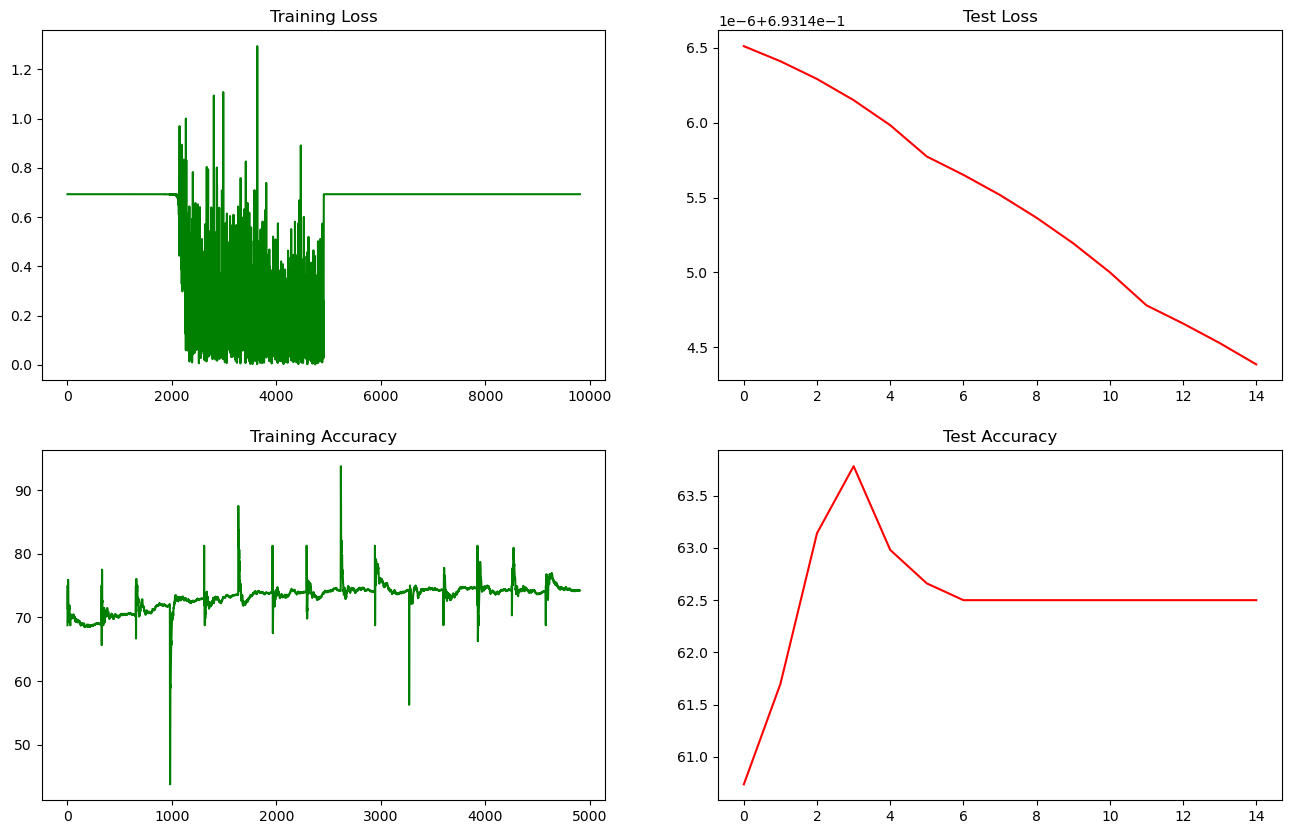

In [61]:
train_losses1 = [float(i.cpu().detach().numpy()) for i in train_losses]
train_acc1 = [i for i in train_acc]
test_losses1 = [i for i in test_losses]
test_acc1 = [i for i in test_acc]
fig, axs = plt.subplots(2,2,figsize=(16,10))
axs[0, 0].plot(train_losses1, color='g')
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc1, color= 'g')
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses1, color = 'r')
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc1, color = 'r')
axs[1, 1].set_title("Test Accuracy")

In [63]:
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ColorJitter(brightness=0.10, contrast=0.1,
    saturation=0.10, hue=0.1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                          [0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                          [0.229, 0.224, 0.225])
])

train_data = datasets.ImageFolder(os.path.join(data_path,'train'), transform= train_transform)

test_data = datasets.ImageFolder(os.path.join(data_path,'test'), transform= test_transform)

    
train_loader = DataLoader(train_data,
                          batch_size= 16, 
                          shuffle= True, 
                          pin_memory= True)
    
test_loader = DataLoader(test_data,
                         batch_size= 1, 
                         shuffle= False, 
                         pin_memory= True)

    
class_names = train_data.classes
print(class_names)
print(f'Number of train images: {len(train_data)}')
print(f'Number of test images: {len(test_data)}')

['NORMAL', 'PNEUMONIA']
Number of train images: 5232
Number of test images: 624


In [64]:
model =  Net().to(mps)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01,
momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.5)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    print('current Learning Rate: ', optimizer.state_dict()
    ["param_groups"][0]["lr"])
    test(model, device, test_loader)

EPOCH: 0


Loss=0.6931008696556091 Batch_id=326 Accuracy=74.22: 100%|█| 327/327 [01:04<00:0


current Learning Rate:  0.01

Test set: Average loss: 0.6931, Accuracy: 390/624(62.50%)

EPOCH: 1


Loss=0.692625880241394 Batch_id=326 Accuracy=74.22: 100%|█| 327/327 [01:04<00:00


current Learning Rate:  0.01

Test set: Average loss: 0.6930, Accuracy: 390/624(62.50%)

EPOCH: 2


Loss=0.6931354999542236 Batch_id=326 Accuracy=74.39: 100%|█| 327/327 [01:04<00:0


current Learning Rate:  0.01

Test set: Average loss: 0.6931, Accuracy: 390/624(62.50%)

EPOCH: 3


Loss=0.6931403875350952 Batch_id=326 Accuracy=74.03: 100%|█| 327/327 [01:03<00:0


current Learning Rate:  0.01

Test set: Average loss: 0.6931, Accuracy: 390/624(62.50%)

EPOCH: 4


Loss=0.6931515336036682 Batch_id=326 Accuracy=73.85: 100%|█| 327/327 [01:04<00:0


current Learning Rate:  0.01

Test set: Average loss: 0.6931, Accuracy: 390/624(62.50%)

EPOCH: 5


Loss=0.6931434869766235 Batch_id=326 Accuracy=74.04: 100%|█| 327/327 [01:04<00:0


current Learning Rate:  0.005

Test set: Average loss: 0.6931, Accuracy: 390/624(62.50%)

EPOCH: 6


Loss=0.6931377053260803 Batch_id=326 Accuracy=73.72: 100%|█| 327/327 [01:04<00:0


current Learning Rate:  0.005

Test set: Average loss: 0.6931, Accuracy: 390/624(62.50%)

EPOCH: 7


Loss=0.6931518316268921 Batch_id=326 Accuracy=73.66: 100%|█| 327/327 [01:04<00:0


current Learning Rate:  0.005

Test set: Average loss: 0.6931, Accuracy: 390/624(62.50%)

EPOCH: 8


Loss=0.6931488513946533 Batch_id=326 Accuracy=73.99: 100%|█| 327/327 [01:03<00:0


current Learning Rate:  0.005

Test set: Average loss: 0.6931, Accuracy: 390/624(62.50%)

EPOCH: 9


Loss=0.6931465268135071 Batch_id=326 Accuracy=73.66: 100%|█| 327/327 [01:04<00:0


current Learning Rate:  0.005

Test set: Average loss: 0.6931, Accuracy: 390/624(62.50%)

EPOCH: 10


Loss=0.6931425929069519 Batch_id=326 Accuracy=73.81: 100%|█| 327/327 [01:03<00:0


current Learning Rate:  0.005

Test set: Average loss: 0.6931, Accuracy: 390/624(62.50%)

EPOCH: 11


Loss=0.6931442022323608 Batch_id=326 Accuracy=73.60: 100%|█| 327/327 [01:04<00:0


current Learning Rate:  0.0025

Test set: Average loss: 0.6931, Accuracy: 390/624(62.50%)

EPOCH: 12


Loss=0.6931507587432861 Batch_id=326 Accuracy=73.72: 100%|█| 327/327 [01:04<00:0


current Learning Rate:  0.0025

Test set: Average loss: 0.6931, Accuracy: 390/624(62.50%)

EPOCH: 13


Loss=0.6931453943252563 Batch_id=326 Accuracy=73.53: 100%|█| 327/327 [01:04<00:0


current Learning Rate:  0.0025

Test set: Average loss: 0.6931, Accuracy: 390/624(62.50%)

EPOCH: 14


Loss=0.6931419372558594 Batch_id=326 Accuracy=73.64: 100%|█| 327/327 [01:04<00:0


current Learning Rate:  0.0025

Test set: Average loss: 0.6931, Accuracy: 390/624(62.50%)



Text(0.5, 1.0, 'Test Accuracy')

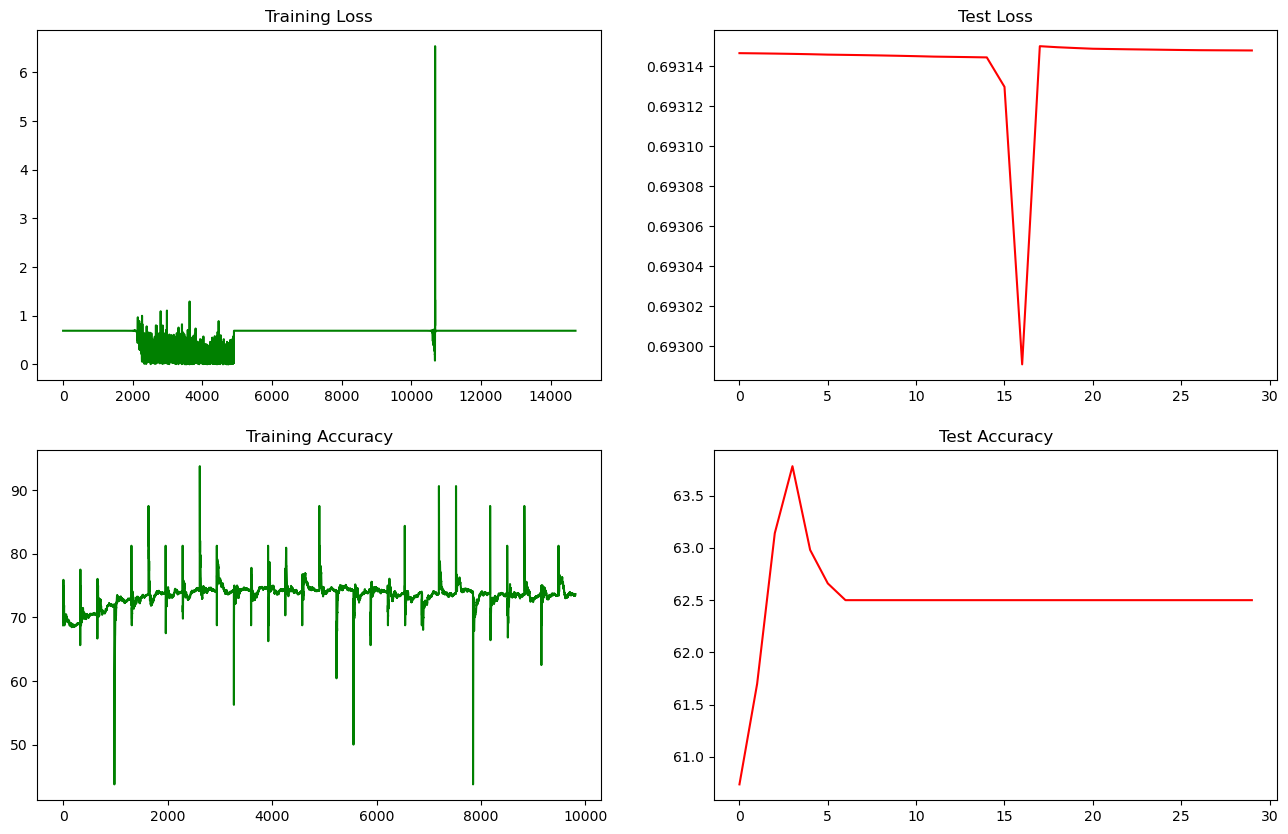

In [65]:
train_losses1 = [float(i.cpu().detach().numpy()) for i in train_losses]
train_acc1 = [i for i in train_acc]
test_losses1 = [i for i in test_losses]
test_acc1 = [i for i in test_acc]
fig, axs = plt.subplots(2,2,figsize=(16,10))
axs[0, 0].plot(train_losses1, color='g')
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc1, color= 'g')
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses1, color = 'r')
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc1, color = 'r')
axs[1, 1].set_title("Test Accuracy")